# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [7]:
!pip3 install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\praveen K G\AppData\Local\Temp\pip-install-radpj8et\tensorflow-gpu_dab686bc4f4b4fc38013dddfecd9b370\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-exited-with-error
  
  Running setup.py install for tensorflow-gpu d

In [8]:
!pip3 install albumentations


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\praveen K G\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [11]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [12]:
!labelme

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [21]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [22]:
images.as_numpy_iterator().next()

b'data\\images\\727ae017-d522-11ed-8858-ac74b1706353.jpg'

In [23]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [24]:
images = images.map(load_image)

In [25]:
images.as_numpy_iterator().next()

array([[[175, 179, 180],
        [175, 179, 180],
        [175, 179, 180],
        ...,
        [ 82,  70,  44],
        [ 81,  69,  43],
        [ 81,  69,  43]],

       [[175, 179, 180],
        [175, 179, 180],
        [175, 179, 180],
        ...,
        [ 81,  71,  44],
        [ 82,  70,  44],
        [ 81,  71,  44]],

       [[175, 179, 178],
        [175, 179, 178],
        [175, 179, 178],
        ...,
        [ 78,  71,  45],
        [ 80,  70,  45],
        [ 78,  71,  45]],

       ...,

       [[195, 195, 197],
        [195, 195, 197],
        [195, 195, 197],
        ...,
        [ 81,  75,  59],
        [ 81,  75,  59],
        [ 82,  76,  60]],

       [[195, 195, 197],
        [195, 195, 197],
        [195, 195, 197],
        ...,
        [ 79,  76,  59],
        [ 79,  76,  59],
        [ 79,  76,  57]],

       [[194, 194, 196],
        [194, 194, 196],
        [194, 194, 196],
        ...,
        [ 78,  77,  59],
        [ 79,  76,  57],
        [ 78,  75,  56]]

In [26]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [27]:
image_generator = images.batch(4).as_numpy_iterator()

In [28]:
plot_images = image_generator.next()

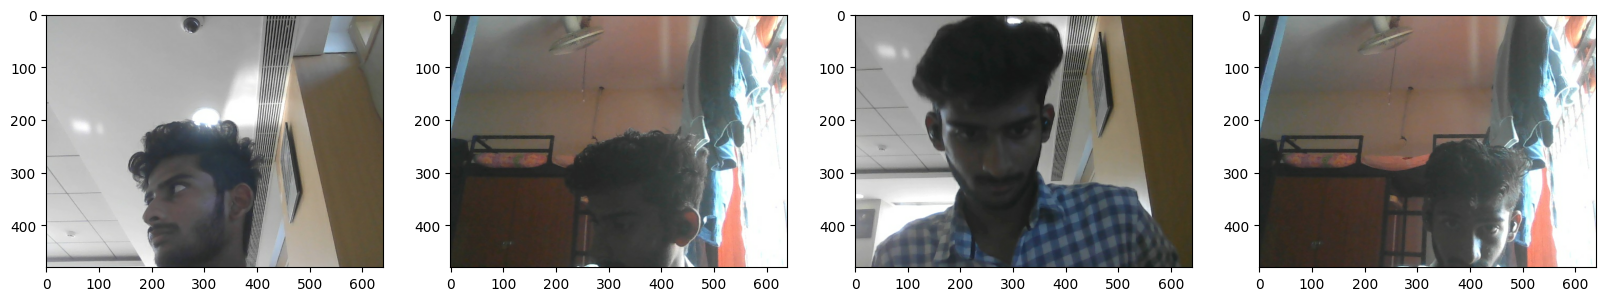

In [29]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [30]:
90*.7 # 63 to train

62.99999999999999

In [31]:
90*.15 # 14 and 13 to test and val

13.5

### 3.2 Move the Matching Labels

In [32]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [33]:
import albumentations as alb

In [34]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [35]:
img = cv2.imread(os.path.join('data','train', 'images','8aeda296-cd58-11ed-beda-ac74b1706353.jpg'))

In [36]:
with open(os.path.join('data', 'train', 'labels', '8aeda296-cd58-11ed-beda-ac74b1706353.json'), 'r') as f:
    label = json.load(f)

In [37]:
label['shapes'][0]['points']

[[273.92156862745094, 264.7549019607843], [474.0138014203403, 479.0]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [38]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [39]:
coords

[273.92156862745094, 264.7549019607843, 474.0138014203403, 479.0]

In [40]:
coords = list(np.divide(coords, [640,480,640,480]))

In [41]:
coords

[0.4280024509803921,
 0.5515727124183006,
 0.7406465647192817,
 0.9979166666666667]

### 4.4 Apply Augmentations and View Results

In [42]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['varun'])

In [43]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [44]:
augmented['bboxes'][0][2:]

(0.7400306698229785, 1.0)

In [45]:
augmented['bboxes']

[(0.29538126361655764, 0.5305664488017429, 0.7400306698229785, 1.0)]

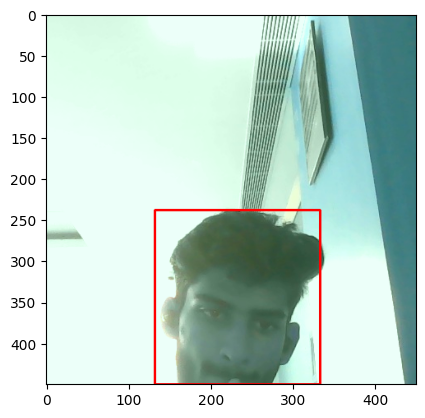

In [46]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [42]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.9166666666666666, 0.9508782679738562, 0.5474877450980392, 0.3258782679738562, 'face'].
x_max is less than or equal to x_min for bbox [0.7818627450980392, 0.890625, 0.425704656862745, 0.3738766339869281, 'face'].
x_max is less than or equal to x_min for bbox [0.6853553921568627, 0.9590482026143791, 0.38664215686274506, 0.46578839869281047, 'face'].
x_max is less than or equal to x_min for bbox [0.621017156862745, 0.9631331699346405, 0.14843749999999994, 0.4280024509803922, 'face'].
x_max is less than or equal to x_min for bbox [0.5988051470588236, 0.9927491830065359, 0.005974264705882315, 0.7772671568627451, 'face'].
x_max is less than or equal to x_min for bbox [0.6409313725490196, 0.9927491830065359, 0.015165441176470562, 0.8344566993464052, 'face'].
x_max is less than or equal to x_min for bbox [0.9947916666666666, 0.7119076797385621, 0.5651041666666666, 0.0021446078431372776, 'face'].
x_max is less than or equal to x_min for bbox [0.7

### 5.2 Load Augmented Images to Tensorflow Dataset

In [47]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [48]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [49]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [50]:
train_images.as_numpy_iterator().next()

array([[[0.41409314, 0.34025735, 0.24068627],
        [0.42990196, 0.3465686 , 0.2509804 ],
        [0.428125  , 0.34479168, 0.24920343],
        ...,
        [0.77254903, 0.77254903, 0.77254903],
        [0.77254903, 0.77254903, 0.77254903],
        [0.77254903, 0.77254903, 0.77254903]],

       [[0.42107844, 0.34264705, 0.24460784],
        [0.4113358 , 0.34859067, 0.24662991],
        [0.4113358 , 0.34957108, 0.2471201 ],
        ...,
        [0.77254903, 0.77254903, 0.77254903],
        [0.77254903, 0.77254903, 0.77254903],
        [0.77254903, 0.77254903, 0.77254903]],

       [[0.41617647, 0.34215686, 0.24264705],
        [0.40741423, 0.3456495 , 0.24319853],
        [0.40686274, 0.35343137, 0.24705882],
        ...,
        [0.76862746, 0.76862746, 0.76862746],
        [0.77205884, 0.77205884, 0.77205884],
        [0.77205884, 0.77205884, 0.77205884]],

       ...,

       [[0.4387255 , 0.3759804 , 0.31501225],
        [0.4401348 , 0.37346813, 0.31072304],
        [0.4504902 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [51]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [52]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [53]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [54]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [55]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8), array([0.271, 0.557, 0.716, 1.   ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [56]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2280, 2280, 480, 480, 480, 480)

### 7.2 Create Final Datasets (Images/Labels)

In [57]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [58]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [59]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [60]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.      , 0.      , 1.      , 0.7754  ],
        [0.      , 0.02686 , 0.4753  , 0.5693  ],
        [0.4744  , 0.04733 , 1.      , 0.7563  ],
        [0.      , 0.005817, 0.624   , 0.7954  ],
        [0.0852  , 0.02908 , 0.792   , 0.882   ],
        [0.01377 , 0.5     , 0.4844  , 0.992   ],
        [0.      , 0.03693 , 0.731   , 0.8267  ],
        [0.      , 0.02734 , 0.5366  , 0.7363  ]], dtype=float16))

### 7.3 View Images and Annotations

In [61]:
data_samples = train.as_numpy_iterator()

In [62]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


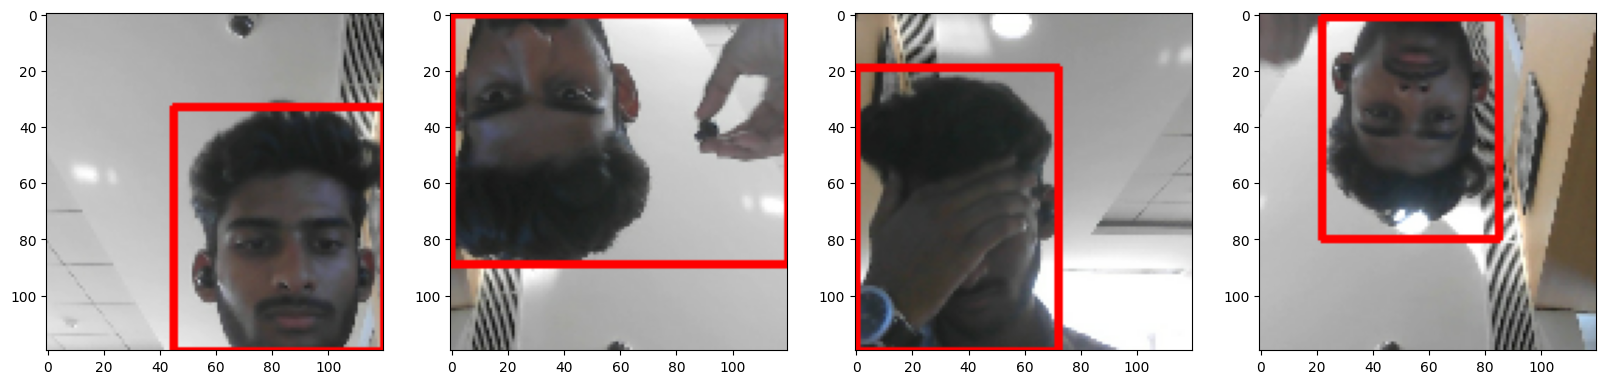

In [63]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [64]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [65]:
vgg = VGG16(include_top=False)

In [66]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [70]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [71]:
facetracker = build_model()

In [72]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [1]:
facetracker.save('C:\\Users\\praveen K G\\Desktop\\desky\\6th sem\\CV\\PROJECT\\FaceDetection-main\\facetracker.h5')

NameError: name 'facetracker' is not defined

In [69]:
from tensorflow import keras
facetracker = keras.models.load_model("C:\\Users\\praveen K G\\Desktop\\desky\\6th sem\\CV\\PROJECT\\FaceDetection-main\\facetracker.h5")

In [73]:
X, y = train.as_numpy_iterator().next()

In [74]:
X.shape

(8, 120, 120, 3)

In [75]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 6s 6s/step


In [76]:
classes, coords

(array([[0.5145755 ],
        [0.4999109 ],
        [0.5705295 ],
        [0.5835901 ],
        [0.58329874],
        [0.5782141 ],
        [0.5478348 ],
        [0.55855066]], dtype=float32),
 array([[0.21947697, 0.44566572, 0.7089212 , 0.24767473],
        [0.2311848 , 0.39228728, 0.5946541 , 0.24057157],
        [0.18580274, 0.38274112, 0.659166  , 0.22785825],
        [0.25278842, 0.42475688, 0.5740362 , 0.2081122 ],
        [0.2521474 , 0.5110684 , 0.6742059 , 0.32895476],
        [0.19318207, 0.38496426, 0.63808924, 0.21355434],
        [0.2167356 , 0.4191299 , 0.6622489 , 0.242234  ],
        [0.2060284 , 0.46986148, 0.6683474 , 0.27472815]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [77]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [78]:
lr_decay

0.0011695906432748536

In [79]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [80]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [81]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [82]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.1950827>

In [83]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.59106773>

In [84]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.1950827>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [85]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [86]:
model = FaceTracker(facetracker)

In [87]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [88]:
logdir='logs'

In [89]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [90]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
285/285 [==============================] - 895s 3s/step - total_loss: 0.2857 - class_loss: 0.0060 - regress_loss: 0.2827 - val_total_loss: 0.0941 - val_class_loss: 2.1309e-06 - val_regress_loss: 0.0941
Epoch 2/10
285/285 [==============================] - 802s 3s/step - total_loss: 0.0622 - class_loss: 9.0328e-06 - regress_loss: 0.0622 - val_total_loss: 0.0699 - val_class_loss: 2.9504e-06 - val_regress_loss: 0.0699
Epoch 3/10
285/285 [==============================] - 642s 2s/step - total_loss: 0.0349 - class_loss: 2.8413e-06 - regress_loss: 0.0349 - val_total_loss: 0.1174 - val_class_loss: 5.0664e-07 - val_regress_loss: 0.1174
Epoch 4/10
285/285 [==============================] - 686s 2s/step - total_loss: 0.0223 - class_loss: 1.2402e-06 - regress_loss: 0.0223 - val_total_loss: 0.0862 - val_class_loss: 1.3411e-07 - val_regress_loss: 0.0862
Epoch 5/10
285/285 [==============================] - 648s 2s/step - total_loss: 0.0256 - class_loss: 9.1491e-07 - regress_loss: 0.0256 

In [93]:
model = model
model.save('C:\\Users\\praveen K G\\Desktop\\desky\\6th sem\\CV\\PROJECT\\FaceDetection-main\\')                        

ValueError: Model <__main__.FaceTracker object at 0x0000026AF47F2110> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.

### 10.3 Plot Performance

In [94]:
hist.history

{'total_loss': [0.1019328236579895,
  0.04638580232858658,
  0.01706678234040737,
  0.012247816659510136,
  0.040284186601638794,
  0.009811253286898136,
  0.016997773200273514,
  0.023841332644224167,
  0.01947121135890484,
  0.012459121644496918],
 'class_loss': [3.8072739698691294e-06,
  1.1757129868783522e-05,
  1.0579838090052363e-06,
  4.2468343508517137e-07,
  1.3411047916633834e-07,
  9.68575761817192e-08,
  2.1606695099762874e-07,
  0.0,
  4.4703494239684005e-08,
  1.3411047916633834e-07],
 'regress_loss': [0.10193091630935669,
  0.046379923820495605,
  0.01706625334918499,
  0.012247604317963123,
  0.04028411954641342,
  0.009811204858124256,
  0.01699766516685486,
  0.023841332644224167,
  0.019471189007163048,
  0.012459054589271545],
 'val_total_loss': [0.0940900593996048,
  0.0698532983660698,
  0.11744219064712524,
  0.08617408573627472,
  0.05331151559948921,
  0.0626046434044838,
  0.05406446382403374,
  0.06057837978005409,
  0.06027683615684509,
  0.05270941928029060

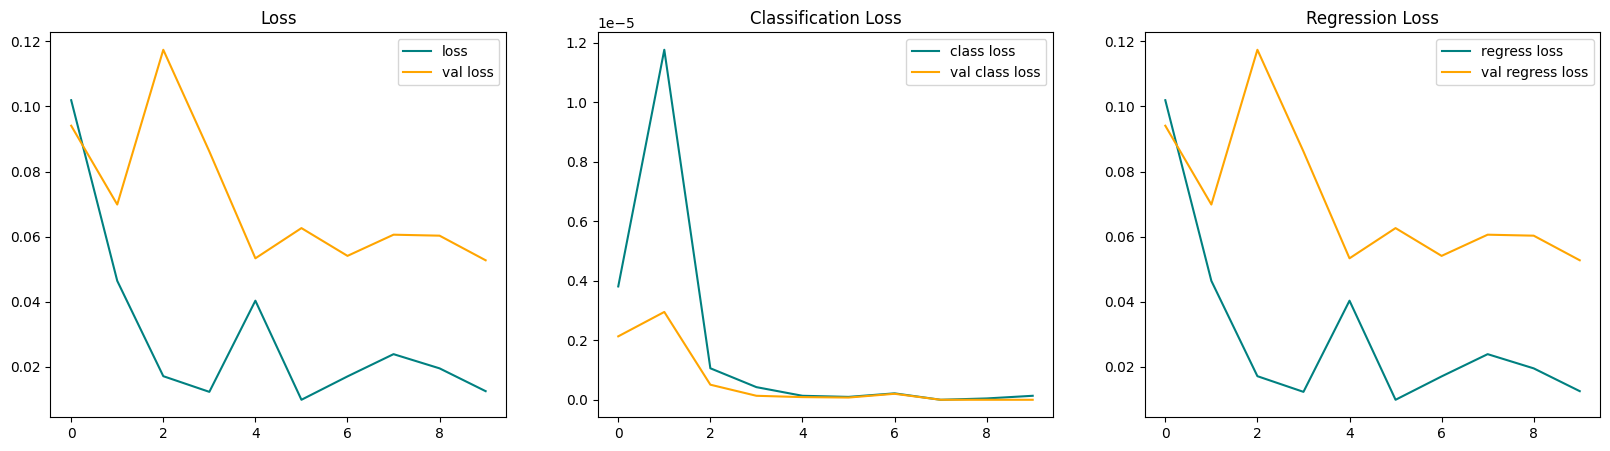

In [95]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [115]:
test_data = test.as_numpy_iterator()

In [116]:
test_sample = test_data.next()

In [117]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 714ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


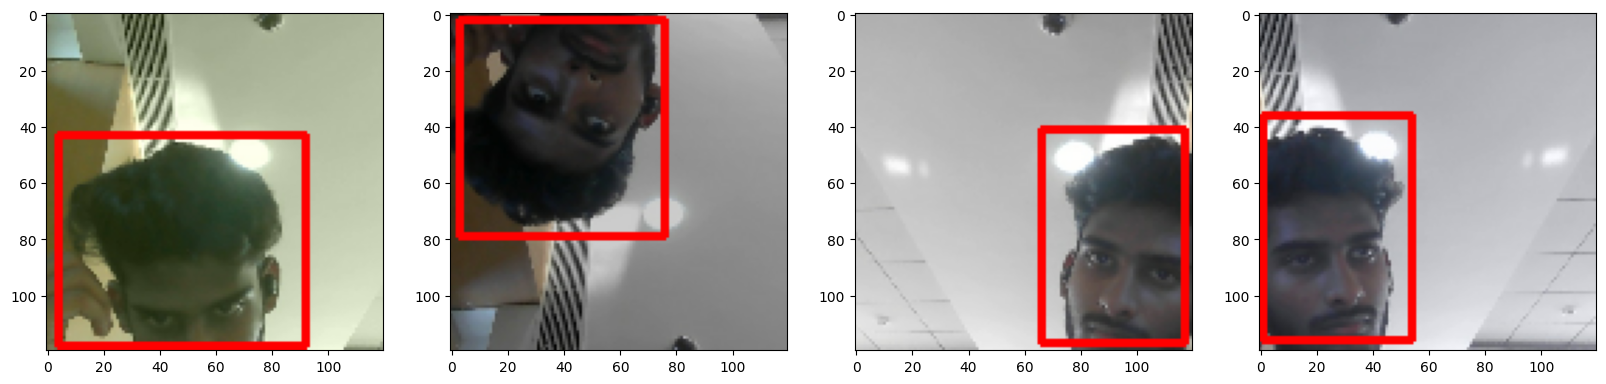

In [118]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [101]:
from tensorflow.keras.models import load_model

In [102]:
facetracker.save('facetracker.h5')

In [103]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [2]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                          (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'varun', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [ ]:
with open('attendance.txt', 'a') as file:
    # Data to be inserted
    data = (yhat, time.time())

    # Write the data to the file
    file.write(data)

print("Data inserted into the file.")